In [2]:
import pandas as pd
import glob
import os
from autorank import autorank, plot_stats, create_report
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'serif'],
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.title_fontsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "lines.markersize": 6,
    "legend.frameon": False,
    "figure.figsize": (9, 3)  # standard size for subplots
})
COLORS = ['#4c90b8', '#2ac3c1', '#f5b811', '#de653e', '#ff912a']
color_dict = {
    'BaselineAll': 'black',
    'BaselineNone': 'gray',
    'DisagreementSampling(DT)': COLORS[3],
    'DisagreementSampling(DS)': COLORS[4],
    'RandomSampling': COLORS[0],
    # add other sampling methods as needed
}
style_map = {
    'BaselineAll':    (color_dict['BaselineAll'], 'o'),
    'BaselineNone':  (color_dict['BaselineNone'], 's'),
    'DisagreementSampling(DT)':    (color_dict['DisagreementSampling(DT)'], 'o'),
    'DisagreementSampling(DS)':  (color_dict['DisagreementSampling(DS)'], '*'),
    'RandomSampling':    (color_dict['RandomSampling'], 'D'),
}

# 0. Load Result Data

In [3]:
# downstream performance and time results
dfs = []
for file_path in glob.glob('results/aggregated_results/results_downstream_*.csv'):
    dfs.append(pd.read_csv(file_path))
df_all = pd.concat(dfs, ignore_index=True)

df_all['sampling_method'] = df_all['sampling_method'].replace({
    'ConsensusSampling(DT)': 'DisagreementSampling(DT)',
    'ConsensusSampling(DS)': 'DisagreementSampling(DS)'
})

In [5]:
# invert sign for running times
df_all.loc[df_all['metric'] == 'total_time', 'value'] *= -1
df_all.loc[df_all['metric'] == 'sampling_time', 'value'] *= -1
df_all.loc[df_all['metric'] == 'model_time', 'value'] *= -1

# cleaner presentation of brackets
df_clean = df_all.copy()
bracket_cleaner = {40: '0-40', 60: '20-60', 80: '40-80', 100: '60-100', 0: 'all', np.nan: 'all'}
df_clean['bracket'] = df_clean['bracket_max'].map(bracket_cleaner)
df_clean = df_clean.drop(['bracket_min', 'bracket_max', 'mean', 'sampling_strategy', 'n_selected'], axis=1)

# joining corresponding baselines
baseline_none = df_clean[df_clean['sampling_method'] == 'BaselineNone'].drop(['bracket', 'sampling_method', 'n_sample'], axis=1).rename(columns={'value': 'baseline_none'})
baseline_all = df_clean[df_clean['sampling_method'] == 'BaselineAll'].drop(['bracket', 'sampling_method', 'n_sample'], axis=1).rename(columns={'value': 'baseline_all'})
df_clean = df_clean[~df_clean['sampling_method'].isin(['BaselineNone', 'BaselineAll'])]
join_keys = ['dataset', 'n_labeled', 'metric', 'seed', 'model']
df_clean = pd.merge(df_clean, baseline_none, on=join_keys, how='left')
df_clean = pd.merge(df_clean, baseline_all, on=join_keys, how='left')
df_clean_avg = df_clean.groupby(['model', 'dataset', 'n_labeled', 'n_sample', 'sampling_method', 'metric', 'bracket'])[['value', 'baseline_none', 'baseline_all']].mean().reset_index()

# finding the best bracket by AUPRC
df_agg = df_clean_avg[df_clean_avg['metric'] == 'auprc_macro']
idx_max_value = df_agg.groupby(['model', 'dataset', 'n_labeled', 'sampling_method', 'n_sample'])['value'].idxmax()
df_best_bracket = df_agg.loc[idx_max_value]
idx_max_value = df_agg.groupby(['model', 'dataset', 'n_labeled', 'sampling_method'])['value'].idxmax()
df_best_nsample_bracket = df_agg.loc[idx_max_value]

# 1. Time Compared to Baselines

How much faster than the baselines is sampling?

In [8]:
# Step 1: Filter to only AUPRC and total_time
df_eff = df_clean_avg[df_clean_avg['metric'].isin(['auprc_macro', 'total_time'])].copy()
# df_eff = df_eff[df_eff['sampling_method'] != 'DisagreementSampling(DS)']  ### <----- or remove DT

# Step 2: Pivot to wide format with value + baselines
df_eff = df_eff.pivot_table(
    index=['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'bracket', 'model'],
    columns='metric',
    values=['value', 'baseline_all', 'baseline_none']
).reset_index()

# Flatten the multi-index columns
df_eff.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df_eff.columns]

# Step 3: Get best row per group (highest value_auprc_macro)
df_best = df_eff.sort_values('value_auprc_macro', ascending=False).groupby(
    ['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'model'], as_index=False
).first()

In [9]:
df_best['time_ratio_to_baseline_all'] = df_best['value_total_time'] / df_best['baseline_all_total_time']

In [10]:
df_time = df_best.groupby(['n_sample','sampling_method'])['time_ratio_to_baseline_all'].mean()
df_time

n_sample  sampling_method         
100       DisagreementSampling(DS)    0.143596
          DisagreementSampling(DT)    0.143947
          RandomSampling              0.147685
250       DisagreementSampling(DS)    0.168035
          DisagreementSampling(DT)    0.167459
          RandomSampling              0.166964
500       DisagreementSampling(DS)    0.208210
          DisagreementSampling(DT)    0.208395
          RandomSampling              0.207847
750       DisagreementSampling(DS)    0.249340
          DisagreementSampling(DT)    0.249677
          RandomSampling              0.250618
1000      DisagreementSampling(DS)    0.281227
          DisagreementSampling(DT)    0.282004
          RandomSampling              0.287861
Name: time_ratio_to_baseline_all, dtype: float64

In [13]:
df_time = df_best.groupby(['model', 'n_sample','sampling_method'])['time_ratio_to_baseline_all'].mean()
df_time

model   n_sample  sampling_method         
Scarf   100       DisagreementSampling(DS)    0.089600
                  DisagreementSampling(DT)    0.089117
                  RandomSampling              0.090573
        250       DisagreementSampling(DS)    0.117057
                  DisagreementSampling(DT)    0.116426
                  RandomSampling              0.118909
        500       DisagreementSampling(DS)    0.161896
                  DisagreementSampling(DT)    0.162370
                  RandomSampling              0.164210
        750       DisagreementSampling(DS)    0.203253
                  DisagreementSampling(DT)    0.203568
                  RandomSampling              0.208608
        1000      DisagreementSampling(DS)    0.233634
                  DisagreementSampling(DT)    0.234637
                  RandomSampling              0.244257
TabNet  100       DisagreementSampling(DS)    0.198077
                  DisagreementSampling(DT)    0.199271
                  Rand

In [11]:
# print(df_time.to_latex())

# 2. Time vs. AUPRC

Close look at the time/performance trade-off

In [14]:
df_plot = df_all.copy()
bracket_cleaner = {40: '0-40', 60: '20-60', 80: '40-80', 100: '60-100', 0: 'all', np.nan: 'all'}
df_plot['bracket'] = df_plot['bracket_max'].map(bracket_cleaner)
df_plot = df_plot.drop(['bracket_min', 'bracket_max', 'mean', 'sampling_strategy', 'n_selected'], axis=1)
df_plot = df_plot[df_plot['metric'].isin(['auprc_macro', 'total_time'])]
df_plot = df_plot[df_plot['n_labeled'].isin([100, 500, 1000])]


In [25]:
df_wide = df_plot.pivot_table(
    index=['dataset', 'seed', 'n_labeled', 'n_sample', 'sampling_method', 'bracket', 'model'],
    columns='metric',
    values='value'
).reset_index()
df_wide['log_total_time'] = np.log(df_wide['total_time'])

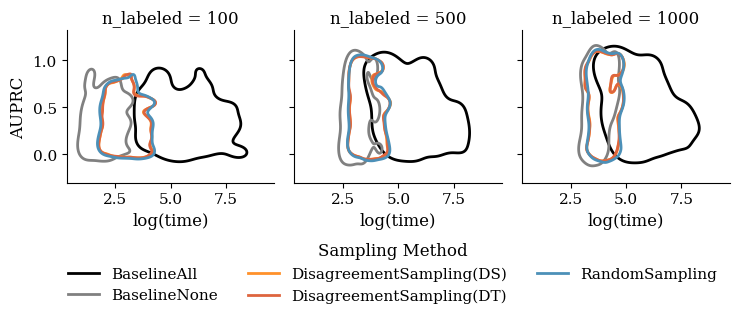

In [26]:
g = sns.FacetGrid(
    df_wide,
    col='n_labeled',
    hue='sampling_method',
    palette=color_dict,
    height=2.5,
    aspect=1,
    sharex=True,
    sharey=True,
)

g.map_dataframe(
    sns.kdeplot,
    x='log_total_time',
    y='auprc_macro',
    fill=False,
    # alpha=0.2,
    linewidth=2,
    thresh=0.1,
    levels=2
)

g.set_axis_labels("log(time)", "AUPRC")
g.set_titles("n_labeled = {col_name}")

# Create one dummy line per sampling method for the legend
handles = [
    mlines.Line2D([], [], color=color_dict[method], label=method, linewidth=2)
    for method in df_wide['sampling_method'].unique()
]

# Add manual legend below the grid
g.fig.legend(
    handles=handles,
    title="Sampling Method",
    loc="lower center",
    bbox_to_anchor=(0.53, -0.29),
    ncol=3,
    frameon=False
)

plt.subplots_adjust(bottom=0.18)
plt.tight_layout()
plt.savefig('plots/3_2_time_vs_auprc.pdf', bbox_inches='tight')
plt.show()


# 3. Time vs. n_sample

In [27]:
join_on = ['dataset', 'n_labeled', 'n_sample', 'model']
df_best_daDT = df_best[df_best['sampling_method'] == 'DisagreementSampling(DT)']
df_best_daDS = df_best[df_best['sampling_method'] == 'DisagreementSampling(DS)'][join_on + ['value_total_time']]
df_best_ra = df_best[df_best['sampling_method'] == 'RandomSampling'][join_on + ['value_total_time']]

In [28]:
df_plot = pd.merge(df_best_daDT, df_best_daDS, on=join_on, how='left')
df_plot = pd.merge(df_plot, df_best_ra, on=join_on, how='left')

In [29]:
fractions = df_best['n_sample'].unique()
competitors= ['baseline_all_total_time', 'baseline_none_total_time', 'value_total_time_x', 
              'value_total_time_y', 'value_total_time']
ranks_per_fraction = []
cds_per_fraction = []

for n_sample in fractions: 
    result = autorank(df_plot[df_plot['n_sample']==n_sample][competitors])

    # Average ranks (dict)
    avg_ranks = result.rankdf['meanrank']

    # CD value from Nemenyi post-hoc
    cd = result.cd

    # Sort ranks by method order
    ordered_ranks = [avg_ranks[method] for method in competitors]

    ranks_per_fraction.append(ordered_ranks)
    cds_per_fraction.append(cd)

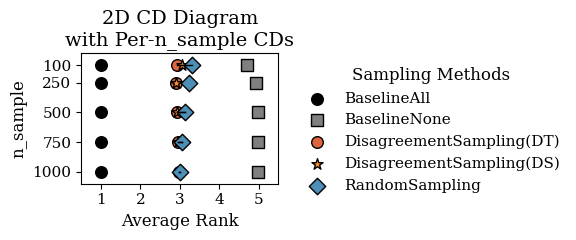

In [30]:
fig, ax = plt.subplots(figsize=(6, 2.5))

# Plot each method's average rank across fractions
for i, method in enumerate(['BaselineAll', 'BaselineNone', 'DisagreementSampling(DT)',
                            'DisagreementSampling(DS)', 'RandomSampling']):
    color, marker = style_map[method]
    ax.scatter(np.array(ranks_per_fraction)[:, i], fractions, color=color, 
               marker=marker, label=method, s=70, edgecolor='k')

# Add CD lines (Nemenyi non-significant comparisons) per row
for i, (frac, cd) in enumerate(zip(fractions, cds_per_fraction)):
    row = ranks_per_fraction[i]
    for j in range(len(competitors)):
        for k in range(j + 1, len(competitors)):
            if abs(row[j] - row[k]) <= cd:
                x1, x2 = row[j], row[k]
                ax.plot([x1, x2], [frac, frac], color='black', linewidth=1)

# Axis formatting
ax.set_ylim(0, 1100)
ax.set_xlim(0.5, len(competitors) + 0.5)
ax.set_yticks(fractions)
ax.set_xlabel("Average Rank")
ax.set_ylabel("n_sample")
ax.invert_yaxis()  # Optional: puts 1.0 on bottom
ax.set_title("2D CD Diagram\nwith Per-n_sample CDs")

# Add rank numbers at the top
ax.set_xticks(np.arange(1, len(competitors) + 1))
ax.set_xticklabels(np.arange(1, len(competitors) + 1))

# Legend
ax.legend(title="Sampling Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('plots/3_3_time_vs_nsample.pdf', bbox_inches='tight')
plt.show()

# 4. Sampling time vs. Training time

In [33]:
df_clean_avg['metric'].unique()

array(['accuracy', 'auc_ovo', 'auprc_macro', 'auprc_weighted', 'f1_macro',
       'f1_weighted', 'model_time', 'precision_macro',
       'precision_weighted', 'recall_macro', 'recall_weighted',
       'sampling_std_dev', 'sampling_time', 'total_time'], dtype=object)

In [38]:
# Step 1: Filter to only AUPRC and total_time
df_eff = df_clean_avg[df_clean_avg['metric'].isin(['sampling_time', 'model_time', 'total_time', 'auprc_macro'])].copy()

# Step 2: Pivot to wide format with value + baselines
df_eff = df_eff.pivot_table(
    index=['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'bracket', 'model'],
    columns='metric',
    values=['value', 'baseline_all', 'baseline_none']
).reset_index()

# Flatten the multi-index columns
df_eff.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df_eff.columns]

# Step 3: Get best row per group (highest value_auprc_macro)
df_best = df_eff.sort_values('value_auprc_macro', ascending=False).groupby(
    ['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'model'], as_index=False
).first()

In [40]:
df_best['sampling_time_ratio'] = df_best['value_sampling_time'] / df_best['value_total_time']
df_time = df_best.groupby(['n_sample','sampling_method'])['sampling_time_ratio'].mean()
df_time

n_sample  sampling_method         
100       DisagreementSampling(DS)    0.029401
          DisagreementSampling(DT)    0.029943
          RandomSampling              0.000021
250       DisagreementSampling(DS)    0.023088
          DisagreementSampling(DT)    0.023952
          RandomSampling              0.000017
500       DisagreementSampling(DS)    0.017510
          DisagreementSampling(DT)    0.017978
          RandomSampling              0.000012
750       DisagreementSampling(DS)    0.013952
          DisagreementSampling(DT)    0.014437
          RandomSampling              0.000009
1000      DisagreementSampling(DS)    0.011851
          DisagreementSampling(DT)    0.012166
          RandomSampling              0.000008
Name: sampling_time_ratio, dtype: float64

In [41]:
df_time = df_best.groupby(['model','sampling_method'])['sampling_time_ratio'].mean()
df_time

model   sampling_method         
Scarf   DisagreementSampling(DS)    0.019561
        DisagreementSampling(DT)    0.020092
        RandomSampling              0.000013
TabNet  DisagreementSampling(DS)    0.018762
        DisagreementSampling(DT)    0.019301
        RandomSampling              0.000014
Name: sampling_time_ratio, dtype: float64

In [42]:
df_time = df_best.groupby(['sampling_method'])['sampling_time_ratio'].mean()
df_time

sampling_method
DisagreementSampling(DS)    0.019163
DisagreementSampling(DT)    0.019698
RandomSampling              0.000014
Name: sampling_time_ratio, dtype: float64